In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import h5py

2022-08-23 03:05:35.953766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 03:05:35.953808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Assume we would like to find "good" mesh to approximate our data. To measure quality of mesh, one could introduce reverse interpolation error.

In [2]:
grid_x, grid_y = np.mgrid[0:78, 0:78]
from scipy.interpolate import griddata
def interpolation(grid_points, data):
    grid_values = data[grid_points[:, 0], grid_points[:, 1]]
    interpolation = griddata(grid_points, grid_values, (grid_x, grid_y),method='linear', fill_value=data.mean(axis=(0, 1)))
    return interpolation

def interpolation_error(grid_points, data):
    interp = interpolation(grid_points, data)
    return np.abs(interp - data).mean()

Minimizing this value via random sampling (e.g. "lazy" annealing) would be too computationally ineffective. Thus, one could use sample points with maximum error from the grid itself. The algorithm itself is:
1. Add edge points as initial ones.
2. Interpolate to regular grid.
3. Find error in each grid point.
4. Add point with maximum error.
5. Repeat 2, 3, 4 until necessary number of points obtained.

In [3]:
def find_best_mesh(data, n_points):
    points = np.array([[0, 0], [0, 77], [77, 0], [77, 77]])
    for _ in range(n_points):
        interp = interpolation(points, data)
        errs = np.abs(data - interp)
        new_point = np.array(np.unravel_index(np.argmax(errs), errs.shape))
        points = np.concatenate([points, new_point[np.newaxis]], axis=0)
    return points

We will use humidity data as an example.

In [4]:
with h5py.File('loc_dataset/2006.grib.hdf5', 'r') as f:
    data = f['map_data'][0][:78, :78, 0, 1]

Let's examine quality of obtained mesh.

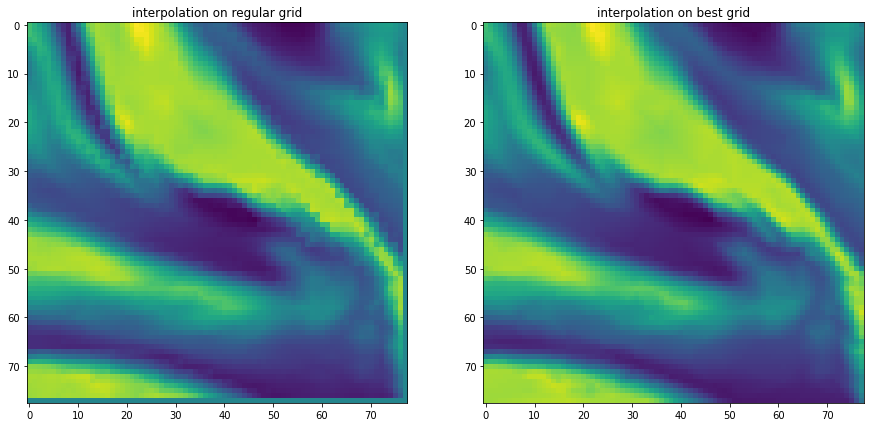

In [5]:
regular_mesh = np.indices((78, 78))[:, ::2, ::2].reshape((2, -1)).T
regular_interp = interpolation(regular_mesh, data)
best_mesh = find_best_mesh(data, 1500)
best_interp = interpolation(best_mesh, data)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].imshow(regular_interp)
axs[0].set_title('interpolation on regular grid')
axs[1].set_title('interpolation on best grid')
axs[1].imshow(best_interp)

One can see visually advantage of our grid. Additionally, let's compare interpolation errors and look at mesh points itself.

In [6]:
print('Best mesh: ', np.abs(data - best_interp).mean())
print('Regular mesh: ', np.abs(data - regular_interp).mean())

Best mesh:  0.5681433662397922
Regular mesh:  1.7101202147481944


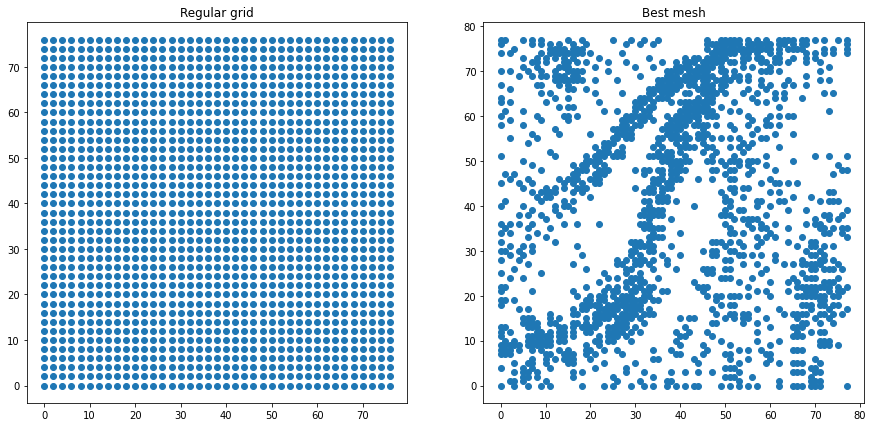

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(regular_mesh[:, 0], regular_mesh[:, 1])
axs[0].set_title('Regular grid')
axs[1].set_title('Best mesh')
axs[1].scatter(best_mesh[:, 0], best_mesh[:, 1])

In addition, we are interested in number of points, necessary for interpolation. For this purpose, let's build how our interpolation error changes with nodes added.

In [8]:
points = np.array([[0, 0], [0, 77], [77, 0], [77, 77]])
errors = []
for _ in range(1500):
    interp = interpolation(points, data)
    errs = np.abs(data - interp)
    errors.append(errs.mean())
    new_point = np.array(np.unravel_index(np.argmax(errs), errs.shape))
    points = np.concatenate([points, new_point[np.newaxis]], axis=0)

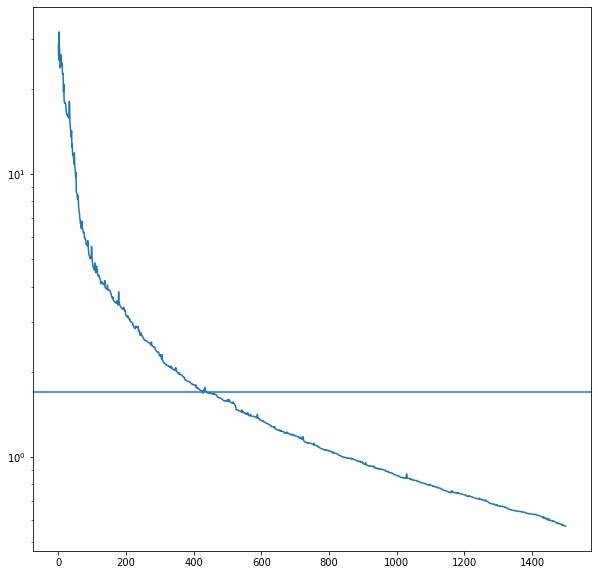

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(errors)
plt.yscale('log')
plt.axhline(1.7)

Now one can see, that we need only 4 times less points to get the same accuracy (comparing to regular mesh). However, the way itself is still extremely unperformant: we need several seconds to find it and the method can not benefit from GPU due to interpolation using Delaunay triangulation.

In [10]:
%timeit find_best_mesh(data, 1500)

9.95 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We could speed it up by taking several points with maximum error at a time, but this is going to lead to many points locating nearby, though this is not what we look for. One way to overcome this obstacle is take local extemas using 2d max pooling. Let's see it visually.

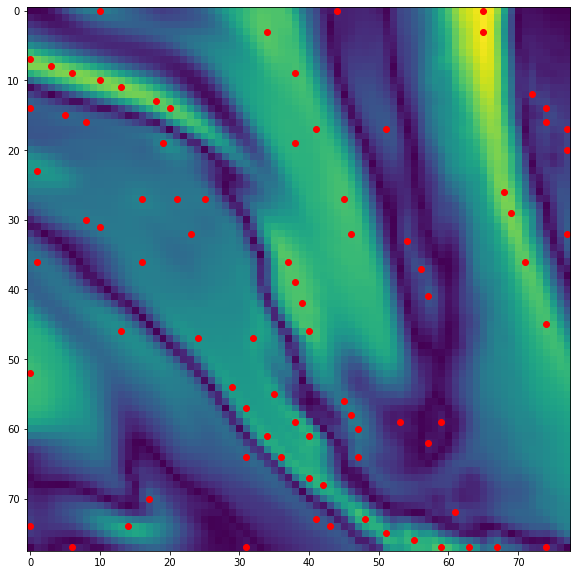

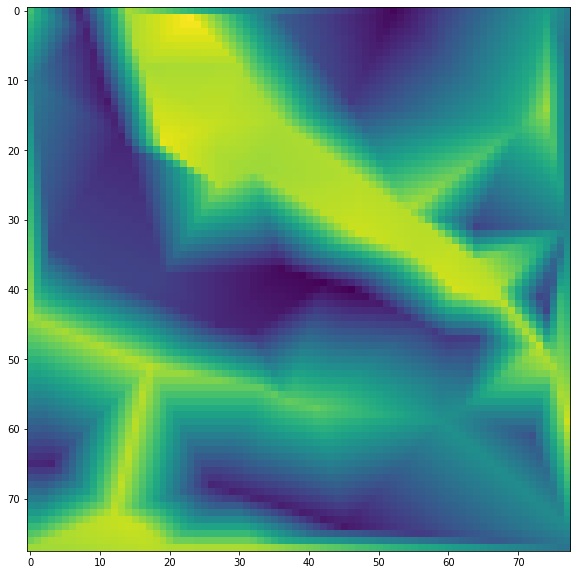

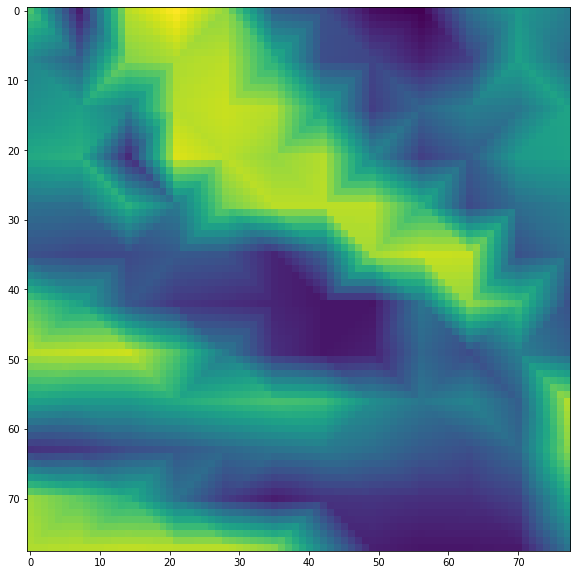

In [11]:
points = np.array([[0, 0], [0, 77], [77, 0], [77, 77]])
interp = interpolation(points, data)
errors = np.abs(interp - data)
max_pooled = maximum_filter(errors, size=(3, 3), mode='constant')
best_points = np.where(max_pooled == errors)
plt.figure(figsize=(10, 10))
plt.imshow(errors.T)
plt.scatter(best_points[0], best_points[1], color='red')
plt.figure(figsize=(10, 10))
plt.imshow(interpolation(np.concatenate([points, np.array(best_points).T], axis=0), data))
plt.figure(figsize=(10, 10))
regular_grid = np.indices((78, 78))[:, ::7, ::7].reshape((2, -1)).T
plt.imshow(interpolation(regular_grid, data))

This process as well might be done several times to obtain necessary number of points.

In [12]:
def find_best_mesh_optimized(data, n_iters):
    points = np.array([[0, 0], [0, 77], [77, 0], [77, 77]])
    for _ in range(n_iters):
        interp = interpolation(points, data)
        errors = np.abs(data - interp)
        max_pooled = maximum_filter(errors, size=(3, 3), mode='constant')
        new_points = np.array(np.where(max_pooled == errors)).T
        points = np.concatenate([points, new_points], axis=0)
    return points

Text(0.5, 1.0, 'Regular')

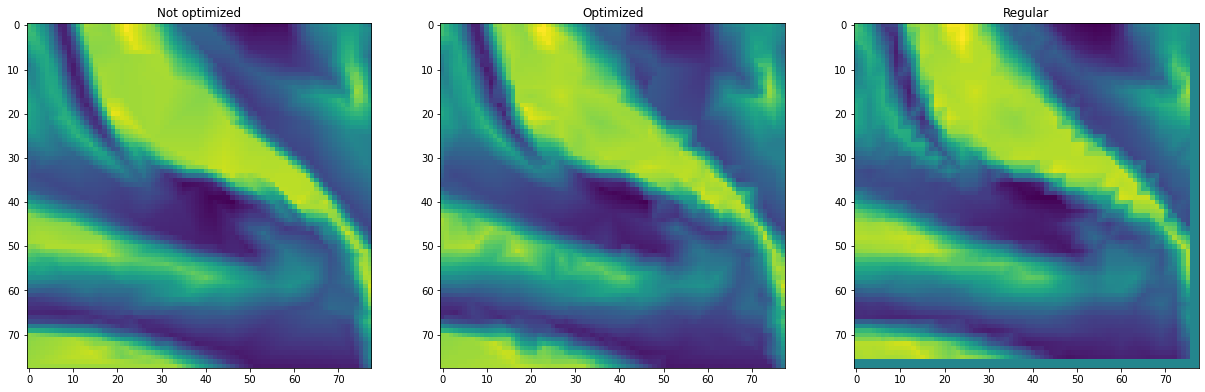

In [13]:
best_mesh_new = find_best_mesh_optimized(data, 3)
best_mesh_old = find_best_mesh(data, 460)
regular_mesh = np.indices((78, 78))[:, ::3, ::3].reshape((2, -1)).T
regular_interp = interpolation(regular_mesh, data)
old_interp = interpolation(best_mesh_old, data)
new_interp = interpolation(best_mesh_new, data)
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs[0].imshow(old_interp)
axs[0].set_title('Not optimized')
axs[1].set_title('Optimized')
axs[1].imshow(new_interp)
axs[2].imshow(regular_interp)
axs[2].set_title('Regular')

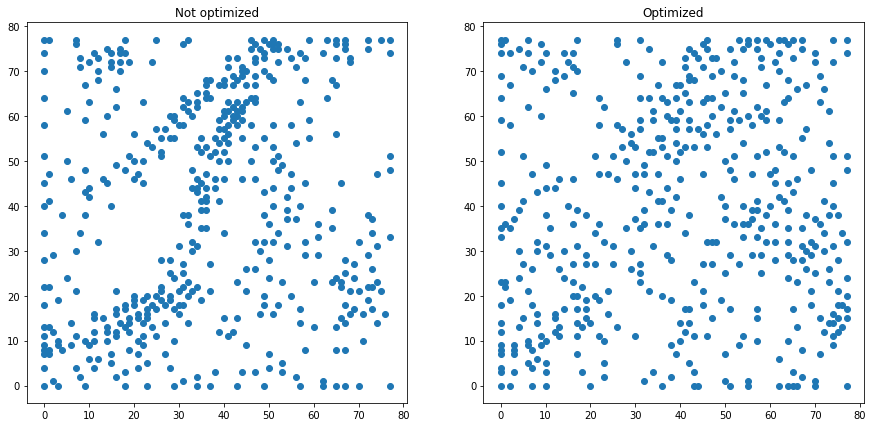

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(best_mesh_old[:, 0], best_mesh_old[:, 1])
axs[0].set_title('Not optimized')
axs[1].set_title('Optimized')
axs[1].scatter(best_mesh_new[:, 0], best_mesh_new[:, 1])

In [15]:
print('Optimized mesh: ', np.abs(data - new_interp).mean())
print('Old mesh: ', np.abs(data - old_interp).mean())
print('Regular mesh: ', np.abs(data - regular_interp).mean())

Optimized mesh:  2.5854921000242728
Old mesh:  1.6756457964078895
Regular mesh:  3.528464653605357


We can see now, that though it is worse than our last mesh, it does still fit better than regular one, containing 1.5x nodes. Let's compare speeds.

In [16]:
%timeit best_mesh_new = find_best_mesh_optimized(data, 3)
%timeit best_mesh_old = find_best_mesh(data, 460)

3.95 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
876 ms ± 5.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Finally, this method is several hundreds times faster, while producing necessary result. It might be still tuned to take not all local extrema, but the highest ones to achieve trade off between mesh quality and performance.
Another question arising is how we can teach machine learning model to predict those nodes. The idea is to build it hierarchically: let's introduce regular part of grid(taking every 7th node of initial grid along every axis, thus having only 1/50th nodes in it). Every such node will be responsible for all the rest 48 nodes around and decide wether they should be taken for next step.

In [17]:
def find_best_mesh_hierarchical(data, n_iters, n_best_points=50):
    #n_best_points for tradeoff between performance and quality
    points = np.indices((78, 78))[:, ::7, ::7].reshape((2, -1)).T
    for _ in range(n_iters):
        interp = interpolation(points, data)
        errors = np.abs(data - interp)
        max_pooled = maximum_filter(errors, size=(3, 3), mode='constant')
        potential_points = np.array(np.where(max_pooled == errors))
        best_ind = np.argpartition(errors[potential_points[0], potential_points[1]], -n_best_points)[-n_best_points:]
        new_points = potential_points[:, best_ind].T
        points = np.concatenate([points, new_points], axis=0)
    return points

We will take n_best_points value equal to 30 and see, that it's speed and quality are acceptable.

1.211710991004697


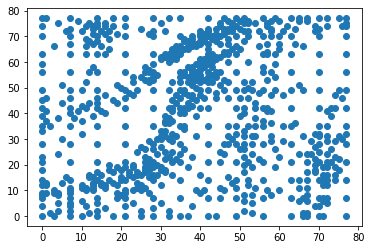

In [18]:
mesh = find_best_mesh_hierarchical(data, 20, n_best_points=30)
plt.scatter(mesh[:, 0], mesh[:, 1])
print(interpolation_error(mesh, data))

In [19]:
%timeit find_best_mesh_hierarchical(data, 20, n_best_points=30)

71.5 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The question arising is which value should be taken for mesh to be chosen. We will normalize all values and summarize them. We will find nodes using knn with 8 neighbors as well(because in regular part of grid 8 neighbors are present). Since a lot of computations have to be done on cpu (with large realtive time to gpu computations) we will preprocess everything before training.

In [20]:
from scipy.spatial import KDTree
def get_edges(nodes):
    kdtree = KDTree(nodes)
    _, neighbors = kdtree.query(nodes, k=9, workers=-1)
    edges = np.stack([np.stack([neighbors[:, 0] for _ in range(8)], axis=-1), neighbors[:, 1:]], axis=-1)
    edges = edges.reshape((-1 ,2))
    return edges.astype(np.int32)

In [21]:
edges = get_edges(mesh)

Let's see obtained mesh.

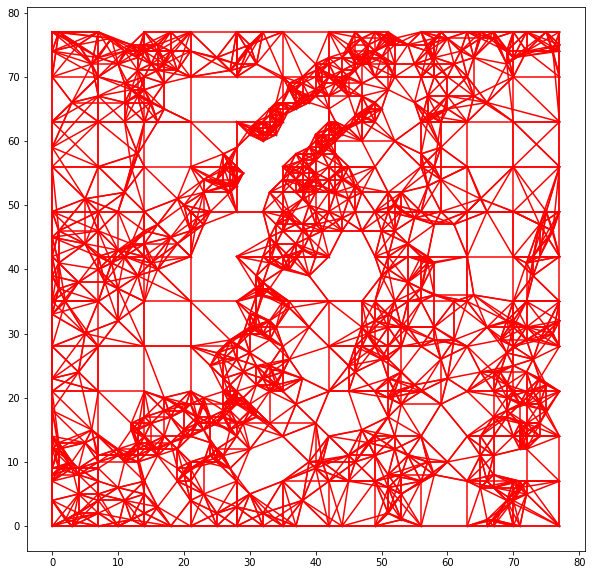

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(mesh[:, 0], mesh[:, 1], s=1)
for edge in edges:
    plt.plot([mesh[edge[0], 0], mesh[edge[1], 0]], [mesh[edge[0], 1], mesh[edge[1], 1]], color='red')

Let's see obtained model performance

In [23]:
from adamesh_pipeline import eval_gen, training_pipeline, training_gen, target_to_nodes, get_edges
import tensorflow as tf
from gnn import Remesher
from normalizer import Normalizer

In [24]:
training_files = ['loc_dataset/2005.grib.hdf5', 
                  'loc_dataset/2006.grib.hdf5',
                  'loc_dataset/2007.grib.hdf5']
mesh_files = ['mesh_data/2005_meshes.hdf5',
             'mesh_data/2006_meshes.hdf5',
             'mesh_data/2007_meshes.hdf5']
def preprocess_hdf5(filename, mesh_filename):
    return tf.data.Dataset.from_generator(training_gen, 
                                         args=(filename, mesh_filename), 
                                         output_signature=(tf.TensorSpec(shape=(81, 81, 4, 6), dtype=tf.float32), 
                                                           tf.TensorSpec(shape=(744, 2), dtype=tf.int32),
                                                          tf.TensorSpec(shape=(5952, 2), dtype=tf.int32),
                                                          tf.TensorSpec(shape=(744, 2), dtype=tf.int32))).map(training_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(training_files), tf.data.Dataset.from_tensor_slices(mesh_files)))
training_dataset = training_dataset.interleave(preprocess_hdf5, num_parallel_calls=tf.data.AUTOTUNE).batch(1).prefetch(tf.data.AUTOTUNE)

2022-08-23 03:18:07.122988: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-23 03:18:07.123022: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MIPTGorbunov): /proc/driver/nvidia/version does not exist
2022-08-23 03:18:07.123541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
normalizer = Normalizer(max_accumulations=10**5)
normalizer.get_stats_edges(training_dataset.map(lambda a, b, c, d: b))
normalizer.get_stats_nodes(training_dataset.map(lambda a, b, c, d: c))

In [26]:
remesher = Remesher()
remesher.load('remesher', 5)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss = lambda true, pred: tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(true, pred, 7))
remesher.compile(optimizer, loss, normalizer, unnormalize=False)

In [28]:
val_frames = list(range(0, 4380, 40))
val_gen = eval_gen('loc_dataset/2011.grib.hdf5', 'mesh_data/2011_meshes.hdf5', val_frames)
acc = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
rec = tf.keras.metrics.Recall(thresholds=0.5)

We will calculate accuracy and recall as our metrics. In addition, let's see how many nodes does model take. Since it should run autoregressively, it's important to keep mesh approximately the same.

In [29]:
from tqdm import tqdm
n_nodes = 0
counter = 0
for el in tqdm(val_gen):
    example = training_pipeline(*el)
    example = tuple(map(lambda x: x[tf.newaxis], example))
    res = remesher((example[0], example[2], example[1], tf.zeros((tf.shape(example[2])[0], tf.shape(example[2])[1], 0))))
    res = tf.nn.sigmoid(res)
    acc.update_state(example[-1], res[:, :144])
    rec.update_state(example[-1], res[:, :144])
    n_nodes += tf.reduce_sum(tf.cast(res[:, :144] > 0.5, tf.float32))
    counter += 1

4it [00:02,  1.67it/s]

5it [00:03,  1.74it/s]

110it [00:52,  2.10it/s]


In [30]:
print('Accuracy: ', acc.result())
print('Recall: ', rec.result())
print('Average nodes number: ', n_nodes/counter)

Accuracy:  tf.Tensor(0.78010976, shape=(), dtype=float32)
Recall:  tf.Tensor(0.7440494, shape=(), dtype=float32)
Average nodes number:  tf.Tensor(1914.6909, shape=(), dtype=float32)


Here one might see trouble. Though we took only approx. 700 nodes for each frame, NN takes much more nodes. One could try to change threshold, but this does not further solve main problem appearing: model performs poorly autoregressively.

In [31]:
val_frames = list(range(5))
val_gen = eval_gen('loc_dataset/2011.grib.hdf5', 'mesh_data/2011_meshes.hdf5', val_frames)

4it [00:03,  1.24it/s]


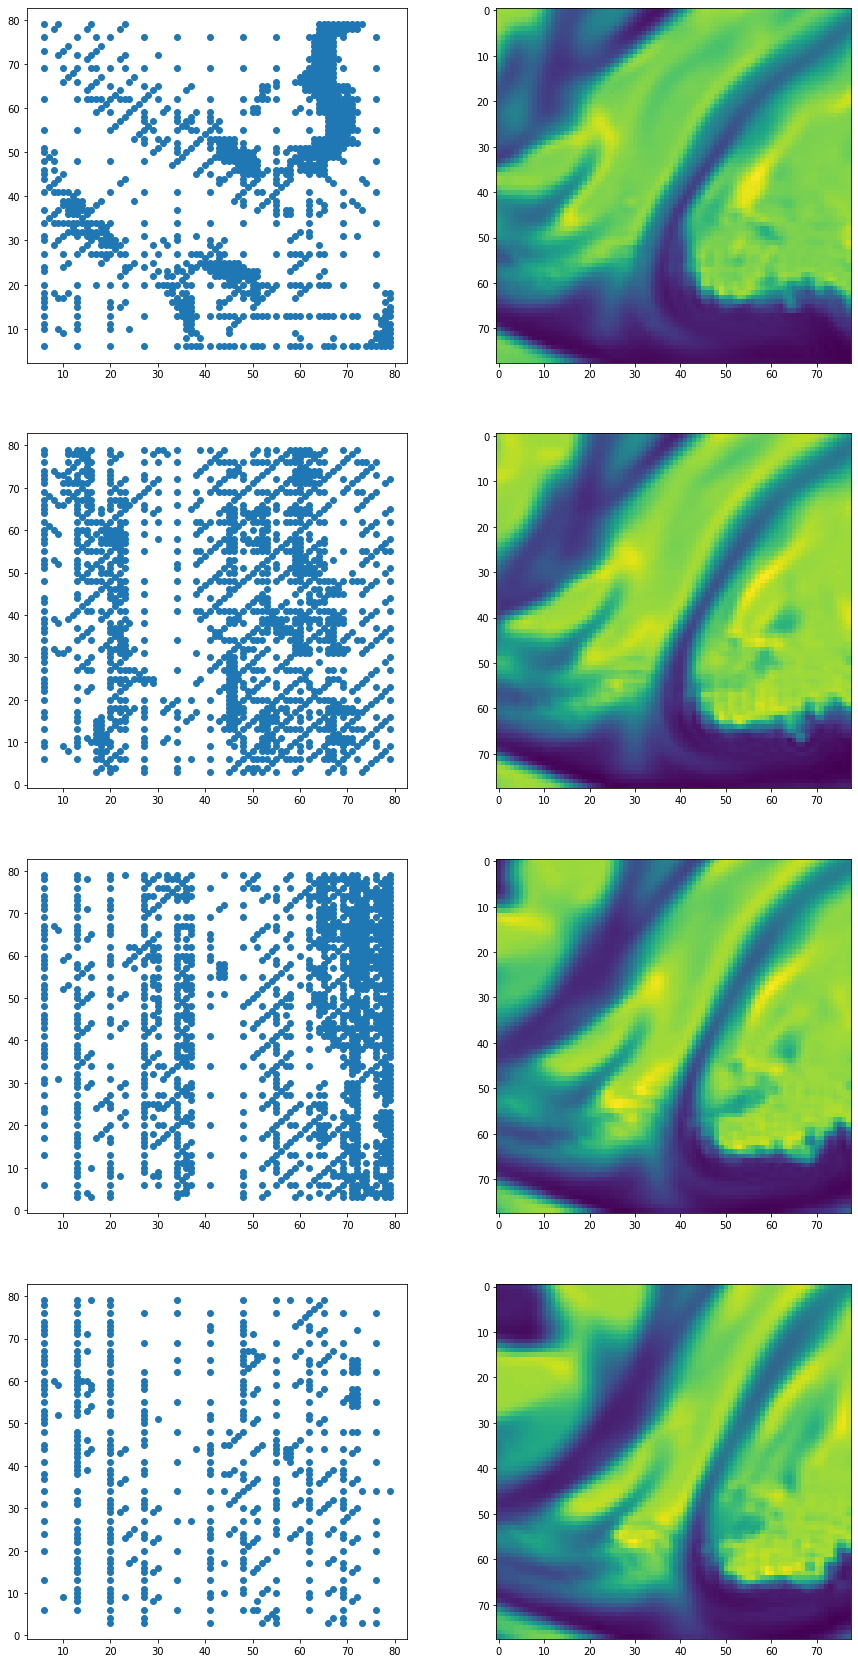

In [32]:
initial = training_pipeline(*next(val_gen))
edges = initial[0][tf.newaxis]
edge_features = initial[1][tf.newaxis]
node_features = initial[2][tf.newaxis]
initial = tuple(map(lambda x: x[tf.newaxis], initial))
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
for i, element in tqdm(enumerate(val_gen)):
    mesh = remesher((edges, node_features, edge_features, tf.zeros((tf.shape(node_features)[0], tf.shape(node_features)[1], 0))))[:, :144]
    mesh = target_to_nodes(mesh[0])
    node_features = tf.gather_nd(element[0], mesh)
    node_features = tf.reshape(node_features, (tf.shape(node_features)[0], -1))[tf.newaxis]
    edges = tf.convert_to_tensor(get_edges(mesh.numpy()))
    senders = tf.reduce_max(edges, axis=1)
    receivers = tf.reduce_min(edges, axis=1)
    packed_edges = tf.stack([senders, receivers], axis=1)
    packed_edges = tf.bitcast(packed_edges, tf.int64)
    unique_edges = tf.bitcast(tf.unique(packed_edges)[0], tf.int32)
    edges = tf.concat([unique_edges, unique_edges[:, ::-1]], axis=0)
    edge_features = tf.gather(mesh, edges)
    edge_features = tf.cast(edge_features[:, 0] - edge_features[:, 1], tf.float32)
    edge_features = tf.concat([tf.expand_dims(tf.linalg.norm(edge_features, axis=-1), 
                                              -1), edge_features], axis=-1)[tf.newaxis]
    edges = edges[tf.newaxis]
    axs[i, 0].scatter(mesh[:, 0], mesh[:, 1])
    axs[i, 1].imshow(element[0][:78, :78, 0, 1])

Also, to see how model generally understands importance of certain nodes, one might look at order of nodes by probability and compare to order of nodes by proposed method.

In [33]:
val_gen = eval_gen('loc_dataset/2011.grib.hdf5', 'mesh_data/2011_meshes.hdf5', [0])
example = next(val_gen)
data = example[0][:78, :78, 0, 1].numpy()
preproc = training_pipeline(*example)
preproc = tuple(map(lambda x: x[tf.newaxis], preproc))
res = remesher((preproc[0], preproc[2], preproc[1], tf.zeros((tf.shape(preproc[2])[0], tf.shape(preproc[2])[1], 0))))
res = res[0, :144]
res = tf.reshape(res, (12, 12, 7, 7))
x = tf.range(78)
y = tf.range(78)
xx, yy = tf.meshgrid(x, y)
grid_indices = tf.stack([yy, xx], axis=-1)
grid_indices = tf.reshape(grid_indices, (-1, 2))
hier_indices = lambda x: tf.cast(tf.concat([tf.floor((x + 3)/7), 
    (x + 3 - tf.floor((x + 3)/7)*7)], axis=0), tf.int32)
grid_indices = tf.vectorized_map(hier_indices, tf.cast(grid_indices, tf.float32))
grid_indices = tf.reshape(grid_indices, (78, 78, 4))
nn_values = tf.gather_nd(res, grid_indices)

points = np.indices((78, 78))[:, ::7, ::7].reshape((2, -1)).T
counter = 0
values = np.zeros((78, 78))
for _ in tqdm(range(5940)):
    counter += 1
    interp = interpolation(points, data)
    errs = np.abs(data - interp)
    new_point = np.array(np.unravel_index(np.argmax(errs), errs.shape))
    values[new_point[0], new_point[1]] = counter
    points = np.concatenate([points, new_point[np.newaxis]], axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5940/5940 [03:17<00:00, 30.12it/s]


Text(0.5, 1.0, 'True order')

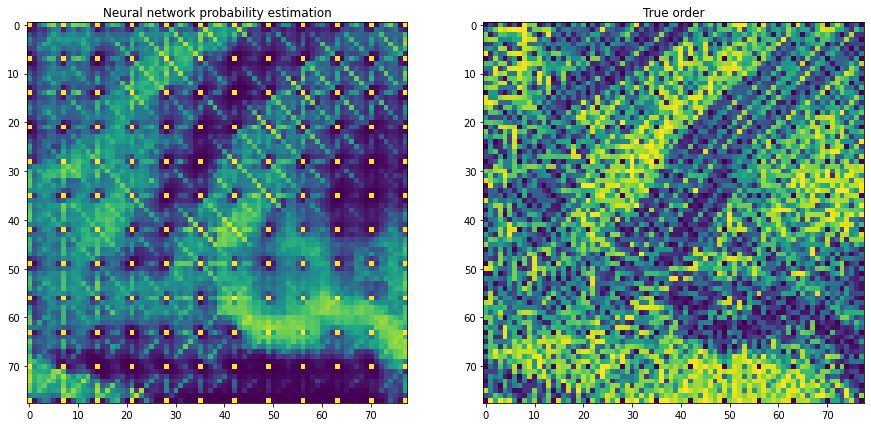

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].imshow(tf.nn.sigmoid(nn_values))
axs[0].set_title('Neural network probability estimation')
axs[1].imshow(values)
axs[1].set_title('True order')

In the picture above, light NN predictions should match dark regions in left plot (and vice versa).